In [1]:
import pandas as pd
import os
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from glob import glob
from torch.optim.lr_scheduler import StepLR
import seaborn as sns

In [2]:
path = os.getcwd()
print(path)

/content


In [3]:
# figure를 위한 라이브러리
import matplotlib as mpl
import matplotlib.lines as mlines

In [4]:
# 글자체 설정
# mpl.rcParams['font.family']='Arial'
mpl.rcParams['font.size']=30

In [5]:
print(mpl.rcParams['font.family'])
print(mpl.rcParams['font.size'])

['sans-serif']
30.0


In [ ]:
# load_csvs의 voltage 조건을 수정하고 fit_spline 함수에 조건값을 같이 수정하면 세그먼트 위치를 바꿔줄 수 있다.
# 여기서 fit spline 함수에서 error의 원인 부분을 주석처리하고 진행 해주어야한다.

In [6]:
def load_csvs(csv_paths):
    ## 파일에 있는 데이터들을 전치리 한후에 모두 다 병합
    data = []
    cycles = []
   
    for path in (csv_paths):
        assert os.path.exists(path) #assert는 os에 해당 path가 존재하지 않으면 AssertError를 발생한다.
        df = pd.read_csv(path)
#         if df.Cycle_Index.unique().shape[0] > 2000:
#             continue
        print(df.Cycle_Index.unique().shape[0])
        df = df[df['Step_Index'] == 10]
        df = df[df['Step_Time'] > 0] # remove outliers
        df = df[df['Step_Time'] < 5000] #remove outliers
        df = df[df["Cycle_Index"] > 0] # remove outliers
            
        df = df[df["Voltage"] <3.21] # data reduction part -> 데이터의 특징을 더 잘나타낼 수 있는 부분 선택
        df = df[df["Voltage"] >2.15] # 학습시킬 voltage segment구간>> 이걸 바꿔가면서 모델링 진행하면됨 원래 2.95 to 2.15
        df["Charge_Capacity"] /= 1.1 # 공칙용량으로 나눠줌 >> 즉 charge_capcity를 퍼센트로 확인 가능
            
        
        data.append(df)
        cycle = df["Cycle_Index"].unique() # 각 파일당 사이클 횟수 저장
        cycles.append(cycle)
        
        print (f"total points in {path}", df.shape)
    
    
    return data, cycles


In [7]:
def plot_cycles(data, cycles):
    print("plotting...")
    for d, cycle in zip(data, cycles):
        for i,c in enumerate(cycle):
            cycle_data = d[d.Cycle_Index == c]
            time, voltage = cycle_data['Step_Time'].values, cycle_data.Voltage 
            try: #동일한 시작점으로 맞춰주는 과정
                time = time - time[0] 
            except:
                print (time, voltage, "skipping")
                continue
            plt.xlabel("time")
            plt.ylabel("voltage")
            # plt.grid(True,axis='y',color='red',in_layout=True) 
            plt.plot(time,voltage)

    plt.grid(True,axis='y',color='red',in_layout=True)       
    plt.show()

In [8]:
def fit_spline(data, cycles, no_points=500): # no_points 구간별 point 개수
    i = 0
    
    for cycle, d in zip (cycles, data):
        cell_np = []
        for index, c in enumerate (cycle):
            cycle_data = d[d["Cycle_Index"] == c]
            
            time, voltage, capacity, ind = cycle_data.Step_Time.values, cycle_data.Voltage, cycle_data.Charge_Capacity, cycle_data.Cycle_Index
            time = time - time[0]
            
            # using spline function to to make dimensions of all cycles equal (to create equal number of points in every cycle)
            ius = InterpolatedUnivariateSpline(time, voltage, k=1) # class 반환

            # creating linear space 0, 200 of 20,000 points >> 0에서 700사이의 20000개의 일정한 간격의 요소를 만듬
            xi = np.linspace(0,700, 20000)
            yi_test = ius(xi) # 불연속인 y값을 대체할 yi_test값 생성

            index_1 = np.argmin(np.abs(yi_test[:1000] - 3.2)) #argmin 최솟값 위치 색인 
            index_2 = np.argmin(np.abs(yi_test - 3)) # 원래 3

            indices = np.linspace(index_1, index_2, no_points).astype(int)

            #discarding points that are greater than time
#             xi = xi[xi < time[-1]]
            #creating indices equal to number of points of xi and selecting 400 equidistant integers
#             indices = np.linspace(0, time[-1]*100 -1, no_points).astype(int)
#             #selecting time at specified indices
            xi = xi[indices]
            yi = ius(xi)
#             if yi[yi<2.998].any(): # 이 부분이 에러의 원인
#                 continue
# 각 변수별 일차원 배열을 생성해주는 과정                       
            ind = np.zeros_like(xi) + ind.values[0] #ind = step_time
            capacity = np.zeros_like(xi) + np.max(capacity)
            cell_np.append(np.array([xi, yi, capacity, ind])) # 리스트에 합침
        cell_np = np.concatenate(cell_np, axis=1) 
        cell_np = np.transpose(cell_np, (1,0)) 
        data[i] = pd.DataFrame(cell_np, columns = ['Step_Time', 'Voltage', 'Charge_Capacity', 'Cycle_Index']) # 데이터 프레임화
        i+=1
        
    return data

In [9]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# mit_csv have pathes of all csv files in raw_mit file(즉 방전상태 뿐만아니라 충전과정 까지 포함한 데이터) > 총 10개의 모집단
mit_csvs = glob("/content/drive/MyDrive//battery capcity estimation//data//*csv")
#glob("./Capacity_data/MIT/*")
for csv in mit_csvs:
    print (csv)
# b1이 들어간 파일은 mit_csv리스트에 담지 않는다
mit_csvs = [i for i in mit_csvs if "b1c21" not in i]


/content/drive/MyDrive//battery capcity estimation//data/2017-05-12_6C-40per_3C_CH26_b1c25_discharge.csv
/content/drive/MyDrive//battery capcity estimation//data/2017-05-12_5_4C-80per_5_4C_CH12_b1c20_discharge.csv
/content/drive/MyDrive//battery capcity estimation//data/2017-05-12_6C-40per_3C_CH25_b1c24_discharge.csv
/content/drive/MyDrive//battery capcity estimation//data/2017-05-12_5_4C-80per_5_4C_CH11_b1c21_discharge.csv
/content/drive/MyDrive//battery capcity estimation//data/2017-05-12_5_4C-60per_3C_CH16_b1c15_discharge.csv
/content/drive/MyDrive//battery capcity estimation//data/2017-05-12_6C-40per_3_6C_CH34_b1c27_discharge.csv
/content/drive/MyDrive//battery capcity estimation//data/2017-05-12_6C-50per_3_6C_CH36_b1c31_discharge.csv
/content/drive/MyDrive//battery capcity estimation//data/2017-05-12_8C-25per_3_6C_CH45_b1c42_discharge_corrected.csv
/content/drive/MyDrive//battery capcity estimation//data/2017-06-30_2C-10per_6C_CH10_b2c1_discharge.csv
/content/drive/MyDrive//batter

In [ ]:
# reducted entire voltage curve
mit_data, mit_cycles = load_csvs(mit_csvs)
# plot_cycles(mit_data, mit_cycles)

852
total points in /content/drive/MyDrive//battery capcity estimation//data/2017-05-12_6C-40per_3C_CH26_b1c25_discharge.csv (232852, 8)
532
total points in /content/drive/MyDrive//battery capcity estimation//data/2017-05-12_5_4C-80per_5_4C_CH12_b1c20_discharge.csv (141377, 8)
1015
total points in /content/drive/MyDrive//battery capcity estimation//data/2017-05-12_6C-40per_3C_CH25_b1c24_discharge.csv (278085, 8)
717
total points in /content/drive/MyDrive//battery capcity estimation//data/2017-05-12_5_4C-60per_3C_CH16_b1c15_discharge.csv (196558, 8)
840
total points in /content/drive/MyDrive//battery capcity estimation//data/2017-05-12_6C-40per_3_6C_CH34_b1c27_discharge.csv (230066, 8)
874
total points in /content/drive/MyDrive//battery capcity estimation//data/2017-05-12_6C-50per_3_6C_CH36_b1c31_discharge.csv (241013, 8)
700
total points in /content/drive/MyDrive//battery capcity estimation//data/2017-05-12_8C-25per_3_6C_CH45_b1c42_discharge_corrected.csv (190044, 12)
170
total points 

In [ ]:
# train cell 로 mi 테스트를 통해 결정할 예정
b1c15 = glob(mit_csvs[0])
b1c15, cycle = load_csvs(b1c15)

852
total points in /content/drive/MyDrive//battery capcity estimation//data/2017-05-12_6C-40per_3C_CH26_b1c25_discharge.csv (232852, 8)


plotting...


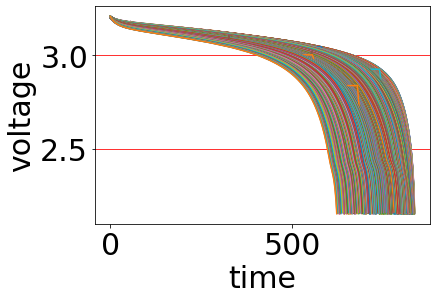

In [ ]:
plot_cycles(b1c15, cycle)

plotting...


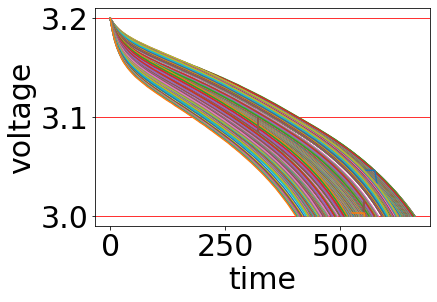

In [ ]:
spline_b1c15 = fit_spline(b1c15.copy(), cycle, no_points=500)
plot_cycles(spline_b1c15, cycle)

In [ ]:
b1c15=spline_b1c15[0]

In [ ]:
y = b1c15.pop('Charge_Capacity')

In [ ]:
X = b1c15
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression
lr= LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
lr.coef_

array([ 3.24235345e-04,  1.11598107e+00, -1.01385286e-04])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


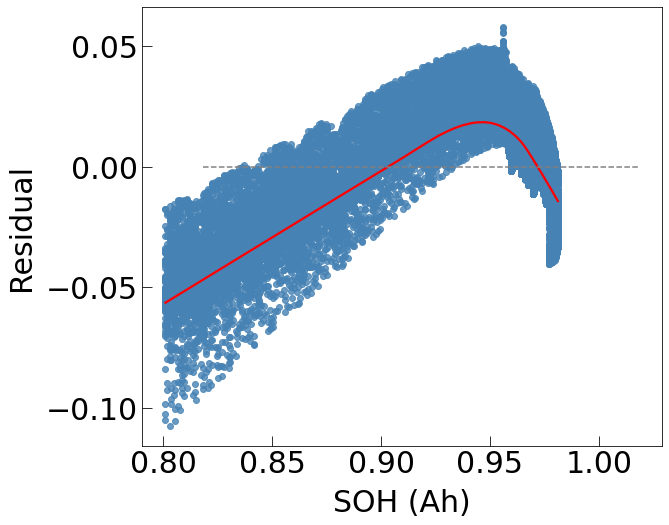

In [ ]:
fig = plt.figure(figsize=(10,8))
residual = y_test - y_pred
sns.regplot(y_test, residual, lowess=True, line_kws={'color': 'red'},color='steelblue')
plt.plot([y_pred.min(), y_pred.max()], [0, 0], '--', color='grey')
plt.tick_params(direction='in',length=10)
# plt.yticks([-0.1,-0.075,-0.05,-0.025,0,0.025,0.05])
plt.ylabel("Residual",labelpad=10)
plt.xlabel('SOH (Ah)',labelpad=10)
plt.tight_layout() # 피규어 안짤리게 해줌
plt.savefig('/content/drive/MyDrive//battery capcity estimation/new figure/잔차의 선형성 검정.png',dpi=600)

In [ ]:
capacity = []
voltage = []
for i in cycle[0]:
    k = b1c15.loc[b1c15.Cycle_Index==i].iloc[0,2]
    v=b1c15.loc[b1c15.Cycle_Index==i].iloc[:,1].tolist()
    capacity.append(k)
    voltage.append(v)

In [ ]:
len(capacity)
# capacity = np.array(capacity)

852

In [ ]:
voltage = np.array(voltage)
voltage.shape
voltage = voltage.reshape(-1)

In [ ]:
voltage.shape

(426000,)

voltage 곡선과 capacity의 correlation 계산

In [ ]:
np.corrcoef(voltage,capacity)

ValueError: ignored

mi score 계산

In [ ]:
# mi score 전에 int 형으로 변형 해줘야한다.

In [ ]:
voltage = np.around(voltage,6)*1000000 # 정수로 변경시켜주기 위해 소숫점 반올림 후에 1000000을 곱해줌
voltage = voltage.astype(np.int) # 정수화

In [ ]:
from sklearn.feature_selection import mutual_info_regression

mi_score_5=np.mean(mutual_info_regression(voltage,capacity))

# segment width calculation

In [ ]:
mi_score_1 # 3.2 to 3.15

0.7848109549644237

In [ ]:
mi_score_2 # 3.2 to 3.1

0.9798326304401126

In [ ]:
mi_score_3 # 3.2 to 3.05

0.9999949507584213

In [ ]:
mi_score_4  # 3.2 to 3

1.0316650721090168

In [ ]:
mi_score_5 # 3.2 to 2.95

1.0069430533776542

In [ ]:
temp = pd.DataFrame([mi_score_1,mi_score_2,mi_score_3,mi_score_4,mi_score_5])
segment = pd.DataFrame(["0.05","0.1","0.15","0.2","0.25"])
temp = pd.concat([segment,temp],axis=1)

In [ ]:
temp.columns = ["segment_width","mi_score"]
temp['cell_name'] = "b1c25"
temp

,segment_width,mi_score,cell_name
0,0.05,0.864115,b1c25
1,0.1,1.059833,b1c25
2,0.15,1.089450,b1c25
3,0.2,1.092454,b1c25
4,0.25,1.098520,b1c25


In [ ]:
width = temp.copy()

In [ ]:
width = pd.concat([width,temp],axis=0)
width

,segment_width,mi_score,cell_name
0,0.05,0.853135,b1c24
1,0.1,1.056646,b1c24
2,0.15,1.041091,b1c24
3,0.2,1.017469,b1c24
4,0.25,1.003013,b1c24
0,0.05,0.784840,b1c15
1,0.1,1.056646,b1c15
2,0.15,0.979862,b1c15
3,0.2,1.031676,b1c15
4,0.25,1.006936,b1c15


In [ ]:
width = width.sort_values(['cell_name','segment_width'])
width.to_csv('segment_width.csv',index=False)

In [10]:
path = "/content/drive/MyDrive//battery capcity estimation//code//segment_width.csv"
width = pd.read_csv(path)

In [11]:
width

,segment_width,mi_score,cell_name
0,0.05,0.784840,b1c15
1,0.10,0.979833,b1c15
2,0.15,0.999995,b1c15
3,0.20,1.031676,b1c15
4,0.25,1.006936,b1c15
5,0.05,1.010521,b1c20
6,0.10,1.212377,b1c20
7,0.15,1.253350,b1c20
8,0.20,1.268119,b1c20
9,0.25,1.250254,b1c20


In [12]:
cell_name=width['cell_name'].unique().tolist()
b1 = width.loc[width['cell_name'] == cell_name[0]]
b2 = width.loc[width['cell_name'] == cell_name[1]]
b3 = width.loc[width['cell_name'] == cell_name[2]]
b4 = width.loc[width['cell_name'] == cell_name[3]]

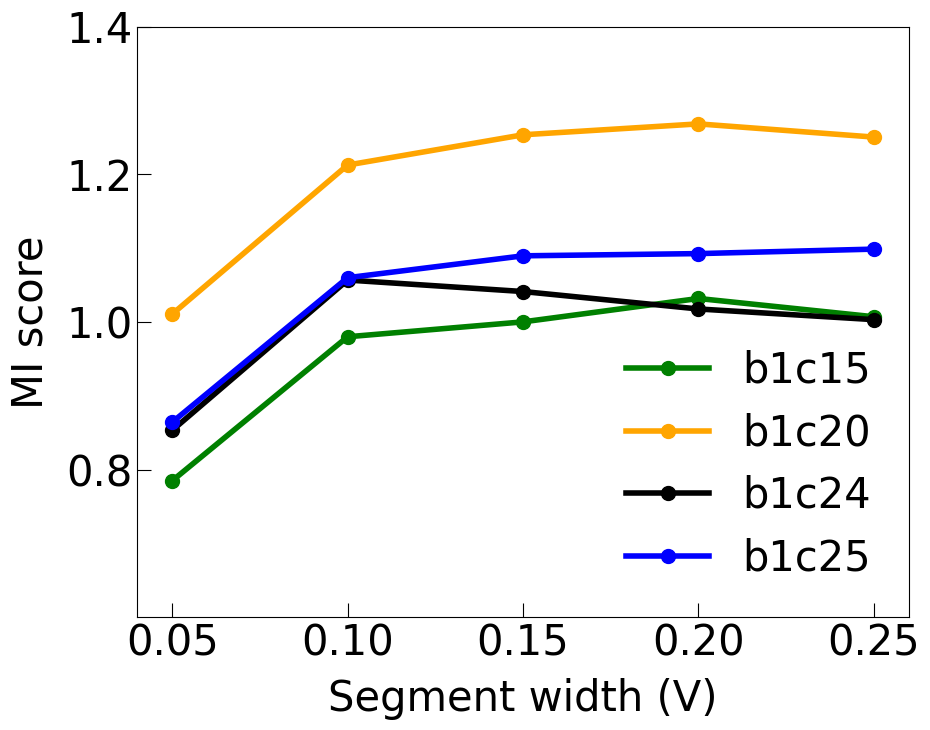

In [23]:
fig = plt.figure(figsize=(10,8))

plt.plot(b1['segment_width'],b1['mi_score'],label='b1c15',color='green',marker = 'o',linewidth=4,markersize=10)

plt.plot(b2['segment_width'],b2['mi_score'],label='b1c20',color='orange',marker = 'o',linewidth=4,markersize=10)

plt.plot(b3['segment_width'],b3['mi_score'],label='b1c24',color='black',marker = 'o',linewidth=4,markersize=10)

plt.plot(b4['segment_width'],b4['mi_score'],label='b1c25',color='blue',marker = 'o',linewidth=4,markersize=10)

plt.xlabel('Segment width (V)',labelpad=10)
plt.ylabel('MI score',labelpad=10)
plt.ylim(0.6,1.4)
plt.yticks(np.arange(0.8,1.6,0.2))
plt.tick_params(direction='in',length=10)
plt.xticks(np.arange(0.05,0.26,0.05))
plt.tight_layout() # 피규어 안짤리게 해줌
plt.legend(frameon=False,loc="lower right")
plt.savefig('/content/drive/MyDrive//battery capcity estimation//new figure//segment_width_MiScore.png',dpi=600)
plt.show()

cell_name
b1c15    AxesSubplot(0.125,0.125;0.775x0.755)
b1c20    AxesSubplot(0.125,0.125;0.775x0.755)
b1c24    AxesSubplot(0.125,0.125;0.775x0.755)
b1c25    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

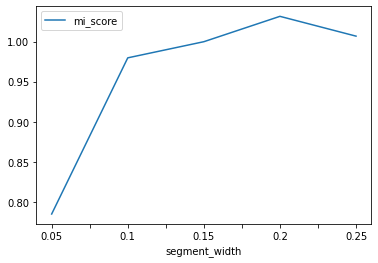

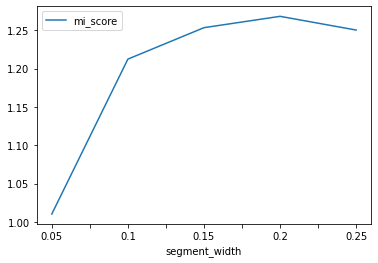

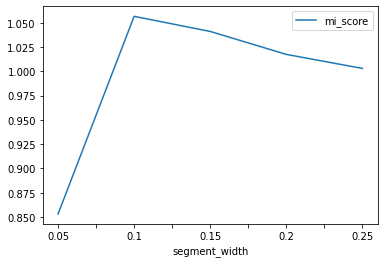

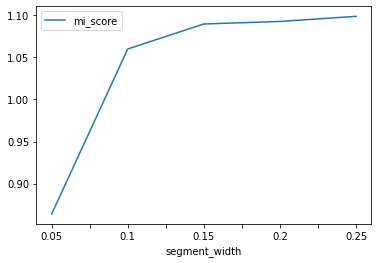

In [ ]:
w.plot(x='segment_width',y='mi_score')

# segment 위치 설정

In [ ]:
mi_score1 # 3.2 to 3 완

1.0924320396241423

In [ ]:
mi_score2 # 3 to 2.8  완

0.8924838024221863

In [ ]:
mi_score3 # 2.8 to 2.6 완

0.6373937670268747

In [ ]:
mi_score4 # 2.6 to 2.4 완

1.129192481378619

In [ ]:
mi_score5 # 2.4 to 2.2 완

0.9855419206661301

In [ ]:
mi_score6 # 2.2 to 2 완

0.009817131657310223

In [ ]:
mi_score7 # 3.4 to 3.2 완

1.007842511403162

In [ ]:
mi_score8 # 3.6 to 3.4 완

0.46031618597282603

In [ ]:
mi_score = []
mi_score.append([mi_score6,mi_score5,mi_score4,mi_score3,mi_score2,mi_score1,mi_score7,mi_score8])
mi_score = mi_score[0]
mi_score = pd.DataFrame(mi_score)

In [ ]:
df = pd.concat([df,mi_score],axis=1)

In [ ]:
df = pd.DataFrame(mi_score,columns=['mi_score'])

In [ ]:
segment = pd.DataFrame(['[2.0,2.2]', '[2.2,2.4]', '[2.4,2.6]', '[2.6,2.8]','[2.8,3.0]','[3.0,3.2]','[3.2,3.4]','[3.4,3.6]'])
df = pd.concat([segment,df],axis=1)

In [ ]:
df.columns=['segment','b1c15','b1c20','b1c24','b1c25']

In [ ]:
세그먼트 = df.iloc[5,:]

In [ ]:
df1 = df.copy().iloc[:,1:]
df1

,b1c15,b1c20,b1c24,b1c25
0,0.007543,0.015114,0.005286,0.009817
1,0.981238,1.170629,1.054174,0.985542
2,1.119594,1.140279,0.889799,1.129192
3,0.829952,0.890069,0.806168,0.637394
4,0.936074,1.036024,0.910566,0.892484
5,1.031655,1.268105,1.017525,1.092432
6,0.766966,0.766966,1.048176,1.007843
7,0.460577,0.325843,0.440214,0.460316


In [24]:
mean = pd.DataFrame([0.009440,1.047896,1.069716,0.790896,0.943787,1.102429,0.897488,0.421738])
segment = pd.DataFrame(['[2.0,2.2]', '[2.2,2.4]', '[2.4,2.6]', '[2.6,2.8]','[2.8,3.0]','[3.0,3.2]','[3.2,3.4]','[3.4,3.6]'])
df = pd.concat([segment,mean],axis=1)
df.columns = ['Segment Location[V]','MI score']

In [ ]:
df['mean']=mean

In [ ]:
mean=df1.mean(axis='columns').tolist()

NameError: ignored

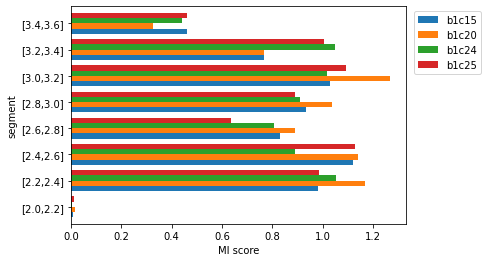

In [ ]:
df.plot.barh(y=['b1c15','b1c20','b1c24','b1c25'],x='segment',width=.8)
plt.xlabel("MI score")
# plt.xlim([0,1.4])
plt.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')

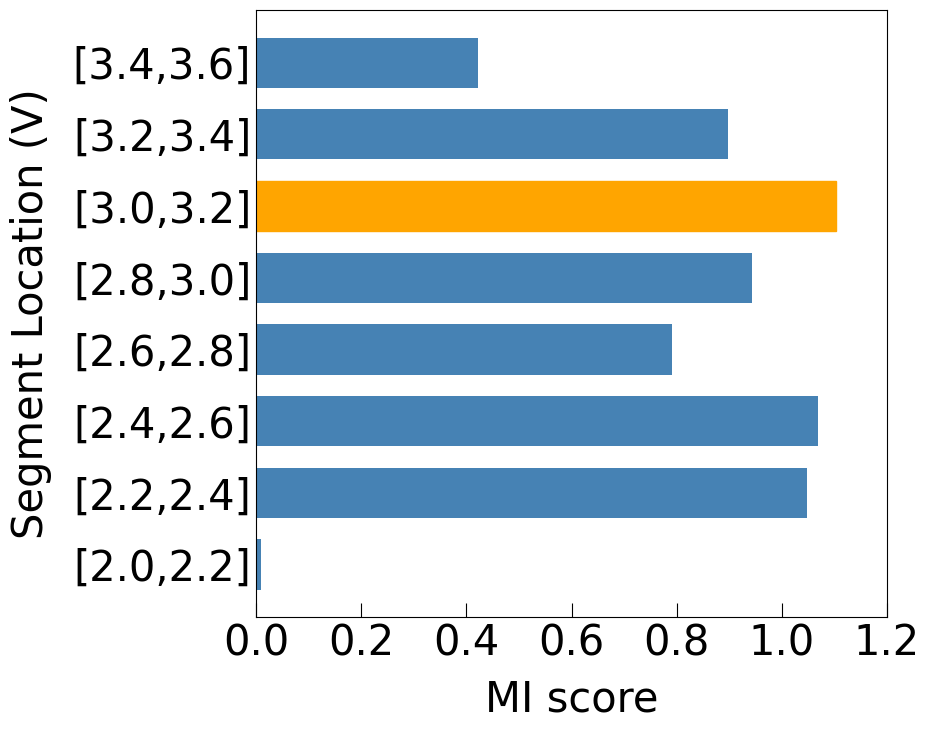

In [28]:
plt.figure(figsize=(10,8))
bar = plt.barh(df['Segment Location[V]'],df['MI score'],label='mean',color='steelblue',height=0.7)
bar[df[df['Segment Location[V]']=='[3.0,3.2]'].index[0]].set_color('orange')
plt.tick_params(direction='in',length=10)
plt.tick_params('y',direction='in',length=0)
plt.xticks(np.arange(0,1.4,0.2))
plt.xlabel('MI score',labelpad=10)
plt.ylabel('Segment Location (V)',labelpad=15)
# plt.legend(frameon=False,fontsize=25)
plt.tight_layout() # 피규어 안짤리게 해줌
plt.savefig('/content/drive/MyDrive//battery capcity estimation/new figure/segment_width_miscore2.png',dpi=600)